# 의사결정트리 분류 기본코드

## #01. 준비작업

### [1] 패키지 가져오기

시각화를 위해서 `graphviz`, `dtreeviz` 패키지가 필요하다

In [134]:
import warnings
warnings.filterwarnings('ignore')

# Intel SKlearn 하드웨어 가속 패치 설정
import sys
if sys.platform == 'win32':
    from sklearnex import patch_sklearn
    patch_sklearn()

from helper.util import *
from helper.plot import *
from helper.analysis import *
from helper.classification import *

# 분석 알고리즘
from sklearn.tree import DecisionTreeClassifier
# 시각화 관련 기능
from sklearn.tree import export_text, plot_tree, export_graphviz
import graphviz
import dtreeviz
from IPython.display import SVG

[autoreload of helper.plot failed: Traceback (most recent call last):
  File "c:\Users\hyk\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\hyk\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\extensions\autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "c:\Users\hyk\AppData\Local\Programs\Python\Python311\Lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 936, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1074, in get_code
  File "<frozen importlib._bootstrap_external>", line 1004, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "c:\Users\hyk\AppData\Local\Programs\Python\

## #02. 이진분류 - 피마 인디언 당뇨병 데이터 셋

### [1] 데이터 가져오기

In [135]:
origin = my_read_excel("https://data.hossam.kr/mldata/pima_indians_diabetes.xlsx", categories=['Outcome'], info=False)

### [2] 데이터 전처리

1. 종속변수 라벨링 및 형변환
2. 훈련/검증 데이터 분리

In [136]:
# 정제 대상 필드명
zero_features = ['Glucose', 'BloodPressure','SkinThickness','Insulin','BMI']

# `0`값을 결측치로 대체후 평균으로 다시 치환
df = origin.copy()
df[zero_features] = df[zero_features].replace(0, np.nan)
df2 = my_replace_missing_value(df)

df2['Outcome'] = df2['Outcome'].astype('int')

x_train, x_test, y_train, y_test = my_train_test_split(df2, yname='Outcome', test_size=0.2, scalling=False)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

### [3] 의사결정나무 분류 모델 구현

| 하이퍼파라미터       | 설명 | 기본값 | 추천 사항 | `GridSearchCV` 추천값 |
|---------------------|------|--------|-----------|------------------------|
| * `criterion`         | 노드를 분할할 기준. 'gini'는 지니 불순도를, 'entropy'는 정보 이득을 사용함 | 'gini' | 문제에 따라 다르지만, 일반적으로 두 기준 중 하나를 선택해서 실험해보는 걸 권장 | `{'criterion': ['gini', 'entropy']}` |
| `splitter`          | 각 노드에서 분할을 선택하는 방식. 'best'는 최선의 분할을 찾으려고 하고, 'random'은 무작위로 분할을 선택함. | 'best' | 대규모 데이터셋이나 무작위성을 추가하고 싶을 때 'random'을 고려할 수 있음 | `{'splitter': ['best', 'random']}` |
| `max_depth`         | 트리의 최대 깊이를 제한. 깊이가 깊어질수록 모델은 더 복잡해지고 과적합될 가능성이 높아짐 | None   | 과적합을 방지하기 위해 적절한 값으로 설정하는 것이 중요. 데이터와 문제에 따라 최적의 값을 찾아봐함 | `{'max_depth': [None, 10, 20, 30, 40, 50]}` |
| * `min_samples_split` | 노드를 분할하기 위해 필요한 최소 샘플 수. 이 값이 클수록 분할이 적게 일어나 트리가 간단해짐 | 2      | 불필요한 분할을 줄이기 위해 이 값을 조정할 수 있음. 크로스 밸리데이션을 통해 적절한 값을 찾아봐야 함 | `{'min_samples_split': [2, 5, 10]}` |
| * `min_samples_leaf`  | 리프 노드가 되기 위해 필요한 최소 샘플 수. 이 값도 클수록 모델이 단순해지고 과적합을 방지할 수 있음 | 1      | 리프 노드의 크기를 조정하여 과적합을 방지할 수 있음 데이터의 특성에 맞게 조정해보는 걸 권장. | `{'min_samples_leaf': [1, 2, 4]}` |
| `max_features`      | 최적의 분할을 찾기 위해 고려할 최대 특성 수. | None   | 이 값을 조정함으로써 모델의 다양성을 높이고 과적합을 줄일 수 있음. 하지만, 너무 낮게 설정하면 모델 성능이 떨어질 수 있음. | `{'max_features': ['auto', 'sqrt', 'log2', None]}` |

In [137]:
estimator = DecisionTreeClassifier(random_state=777, max_depth=3)
estimator.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=777)

### [4] 결과 확인

#### (1) 텍스트 형태

In [138]:
et = export_text(estimator, 
        feature_names=x_train.columns,
        class_names=['음성', '양성'])
print(et)

|--- Glucose <= 143.50
|   |--- BMI <= 26.95
|   |   |--- BMI <= 26.35
|   |   |   |--- class: 음성
|   |   |--- BMI >  26.35
|   |   |   |--- class: 음성
|   |--- BMI >  26.95
|   |   |--- Glucose <= 107.50
|   |   |   |--- class: 음성
|   |   |--- Glucose >  107.50
|   |   |   |--- class: 음성
|--- Glucose >  143.50
|   |--- Glucose <= 154.50
|   |   |--- Glucose <= 152.50
|   |   |   |--- class: 양성
|   |   |--- Glucose >  152.50
|   |   |   |--- class: 음성
|   |--- Glucose >  154.50
|   |   |--- Insulin <= 629.50
|   |   |   |--- class: 양성
|   |   |--- Insulin >  629.50
|   |   |   |--- class: 음성



#### (2) 그래픽 시각화

기존에 사용되던 `Graphivz`는 사용을 위해서 별도의 그래픽 처리 프로그램을 설치해야 하는 번거로움이 있어서 최근에는 이를 대체하기 위한 `plot_tree` 함수를 주로 사용한다.

기본 파라미터는 `export_text()`와 동일.

##### 기본 트리

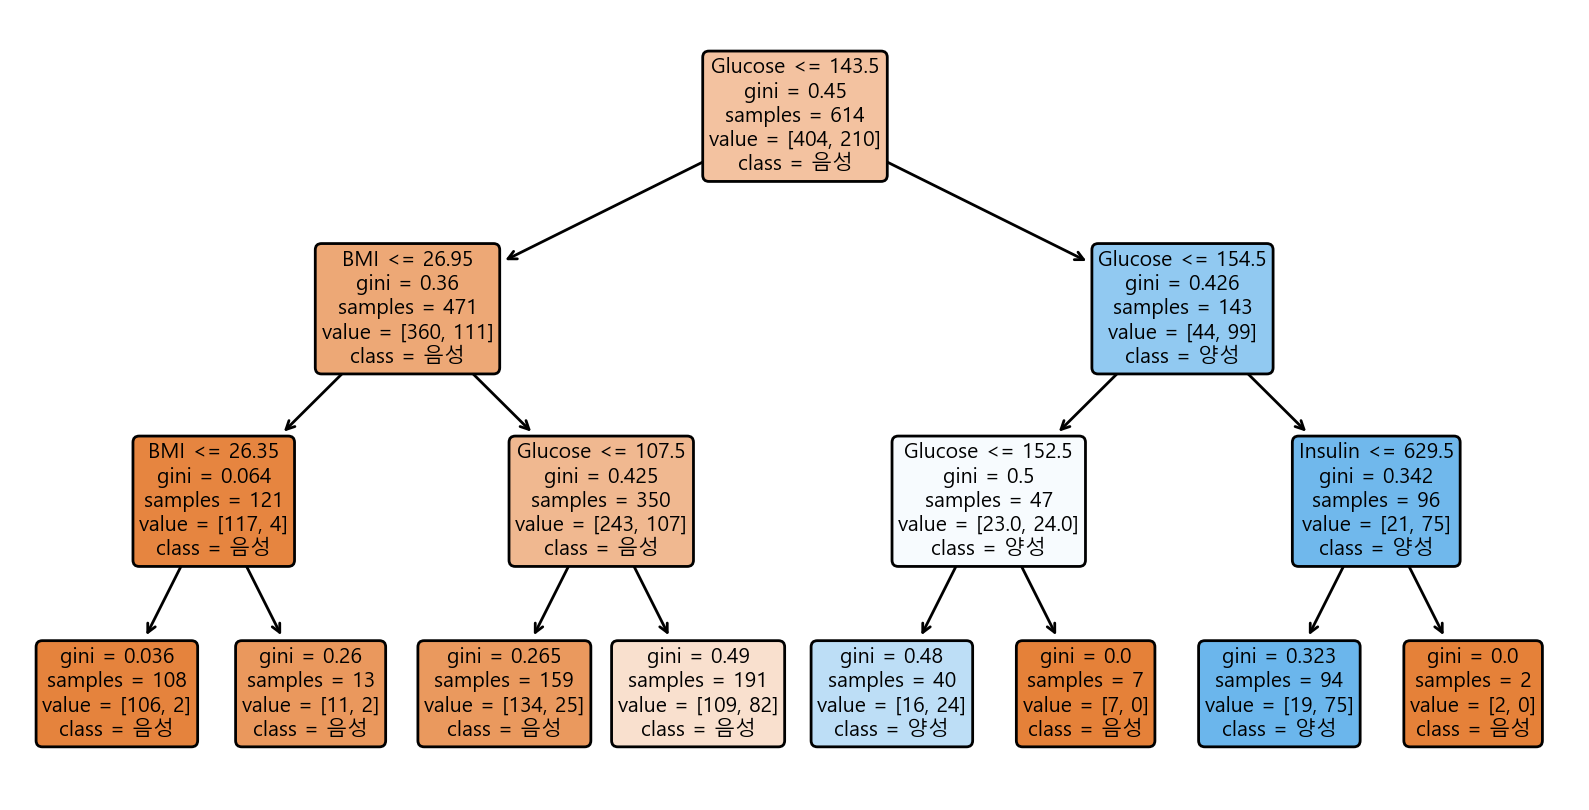

In [139]:
plt.figure(figsize=(10, 5), dpi=200)

# 리턴을 안받으면 그래프가 2개 출력된다. 리턴값을 따로 사용할 것이 아니므로 언더바로 받는다.
_ = plot_tree(estimator,
        feature_names=list(x_train.columns),
        class_names=['음성', '양성'],
        rounded=True,   # 노드의 모서리를 둥글게
        filled=True)     # 노드의 색상을 다르게)

plt.show()
plt.close()

##### graphviz를 통한 트리 시각화


(dot.exe:3984): Pango-WARNING **: couldn't load font "AppleGothic Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.


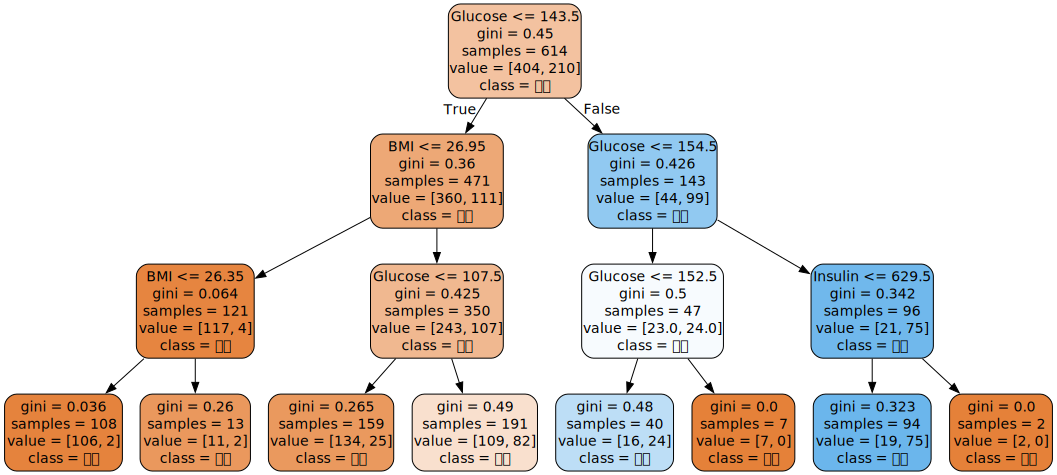

In [140]:
export_graphviz(
    estimator,
    out_file='tree.dot',
    feature_names=list(x_train.columns),
    class_names=['음성', '양성'],
    rounded=True,   # 노드의 모서리를 둥글게
    filled=True,     # 노드의 색상을 다르게
    fontname='AppleGothic'
)

with open("tree.dot", encoding='utf-8') as f:
    dot = f.read()
    display(graphviz.Source(dot))

#### (3) 고급 시각화

`dtreeviz` 패키지의 설치와 참조가 필요하다.


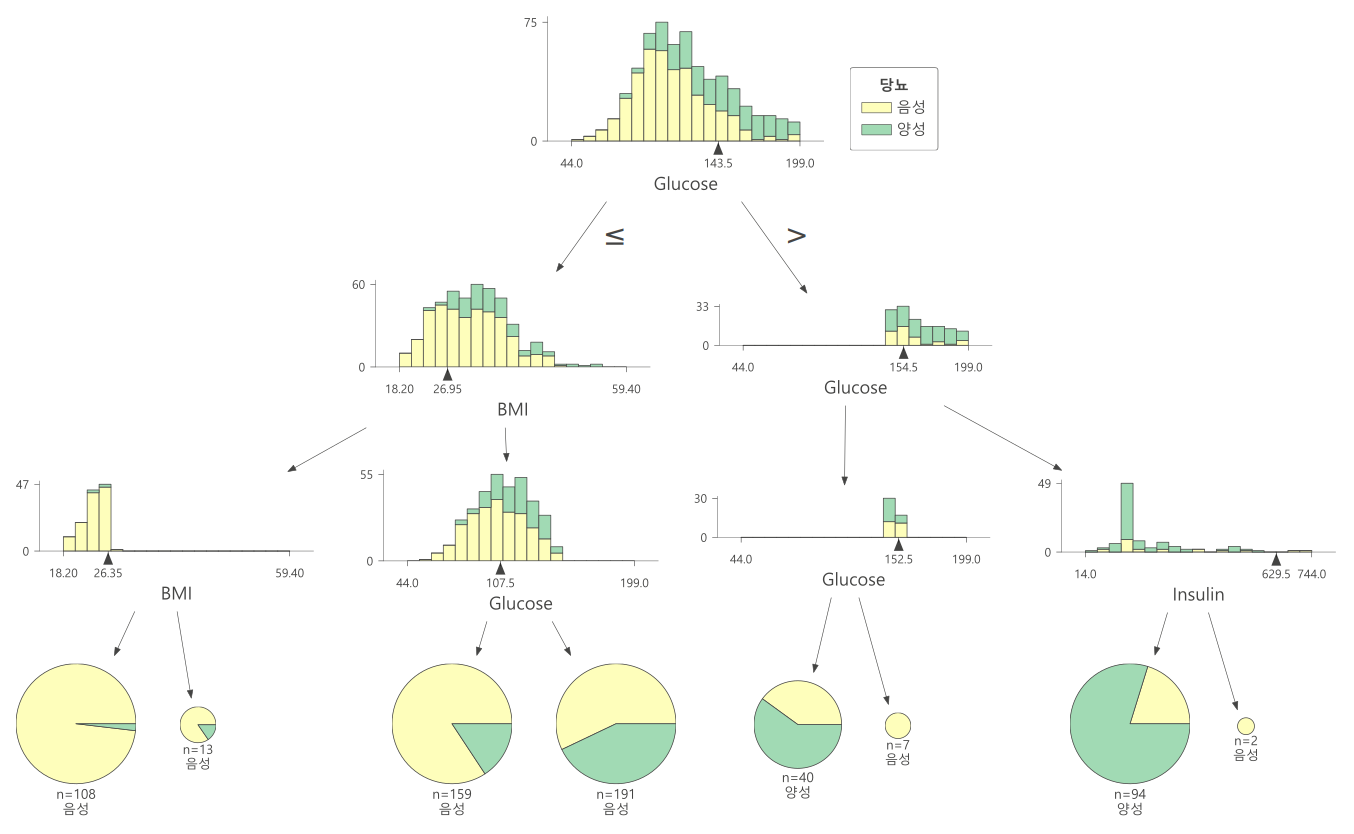

In [148]:
viz = dtreeviz.model(estimator, 
                X_train=x_train,
                y_train=y_train,
                target_name="당뇨",
                feature_names=list(x_train.columns),
                class_names=['음성', '양성'])

viz.view(scale=2.0, fontname= 'Malgun Gothic'if sys.platform == 'win32' else 'AppleGothic')

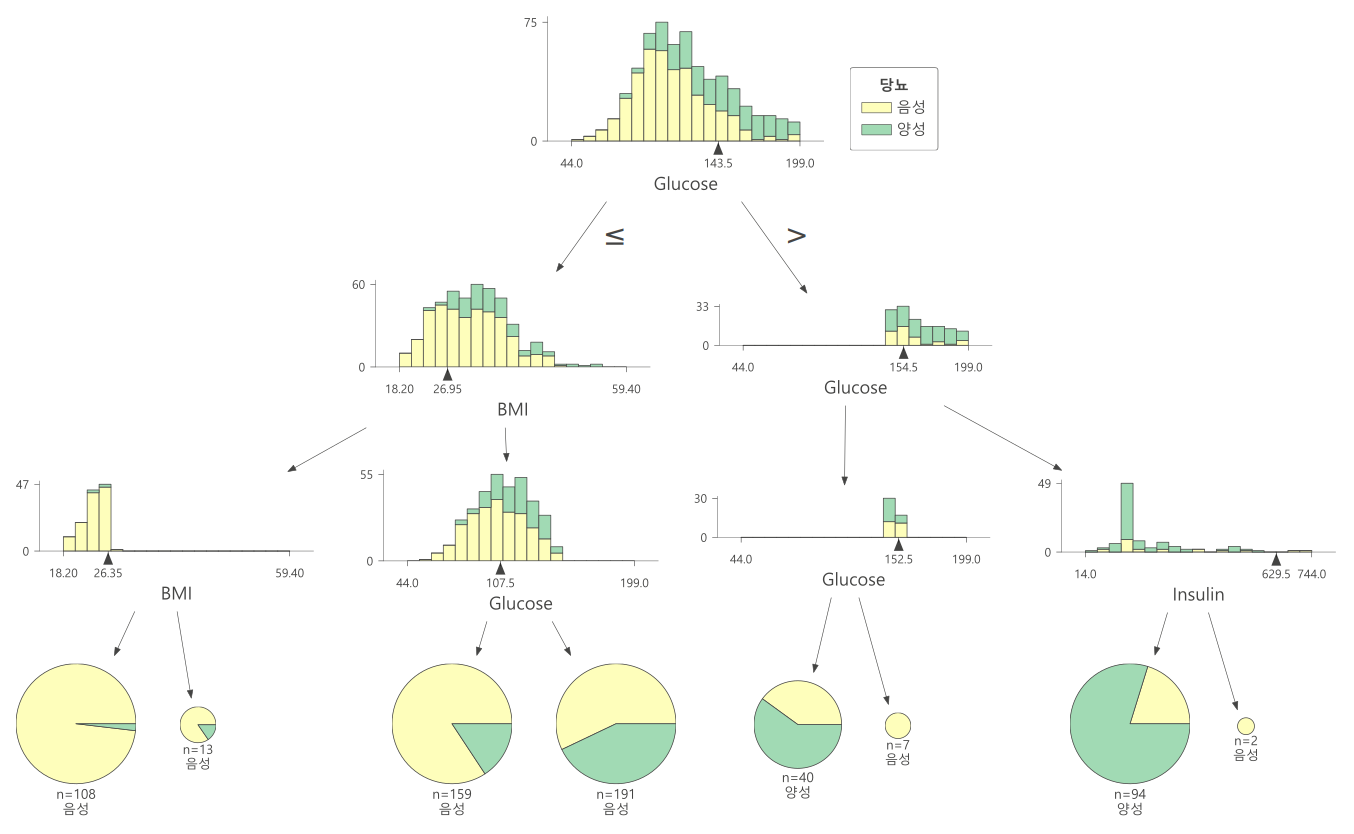

In [142]:
my_dtreeviz(estimator, 
                x_train=x_train,
                y_train=y_train,
                target_name="당뇨",
                class_name=['음성', '양성'])

In [143]:
help(my_dtreeviz)

Help on function my_dtreeviz in module helper.plot:

my_dtreeviz(estimator: sklearn.tree._classes.DecisionTreeClassifier, x_train: pandas.core.frame.DataFrame, y_train: pandas.core.series.Series, target_name: str, class_name: list) -> None
    의사결정나무를 출력한다.
    
    Args:
        estimator (DecisionTreeClassifier): 학습된 의사결정나무 객체
        x_train (DataFrame): 독립변수에 대한 훈련 데이터
        y_train (Series): 종속변수에 대한 훈련 데이터
        target_name (str) : 라벨 제목
        class_name (str) : 라벨링 이름



#### (4) 성능지표 확인

[분류분석 성능평가]
+-------------------+--------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------+--------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |     0.762215 |     0.746753 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |     0.738806 |     0.806452 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재현율(Recall)    |     0.471429 |     0.431034 | 실제 양성(TP,FN) 중 양성(TP)으로 예측한 비율              |
| 위양성율(Fallout) |    0.0866337 |       0.0625 | 실제 음성(FP,TN) 중 양성(FP)으로 잘못 예측한 비율         |
| 특이성(TNR)       |     0.913366 |       0.9375 | 실제 음성(FP,TN) 중 음성(TN)으로 정확히 예측한 비율       |
| F1 Score          |     0.575581 |     0.561798 | 정밀도와 재현율의 조화평균                                |
| AUC               |     0.820539 |      0.79445 | ROC Curve의 면적으로, 1에 가까울수록 좋은 모델            |
+--

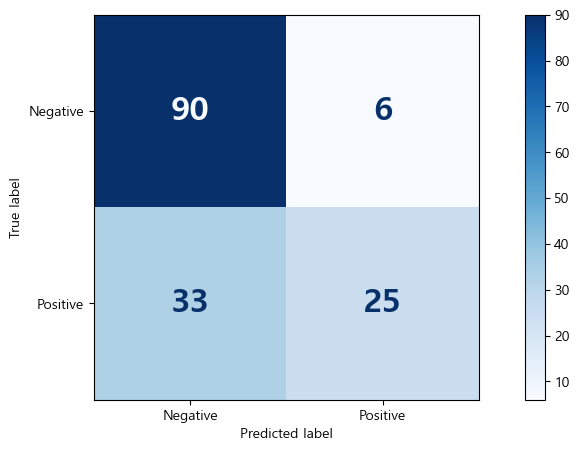

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



[Roc Curve]


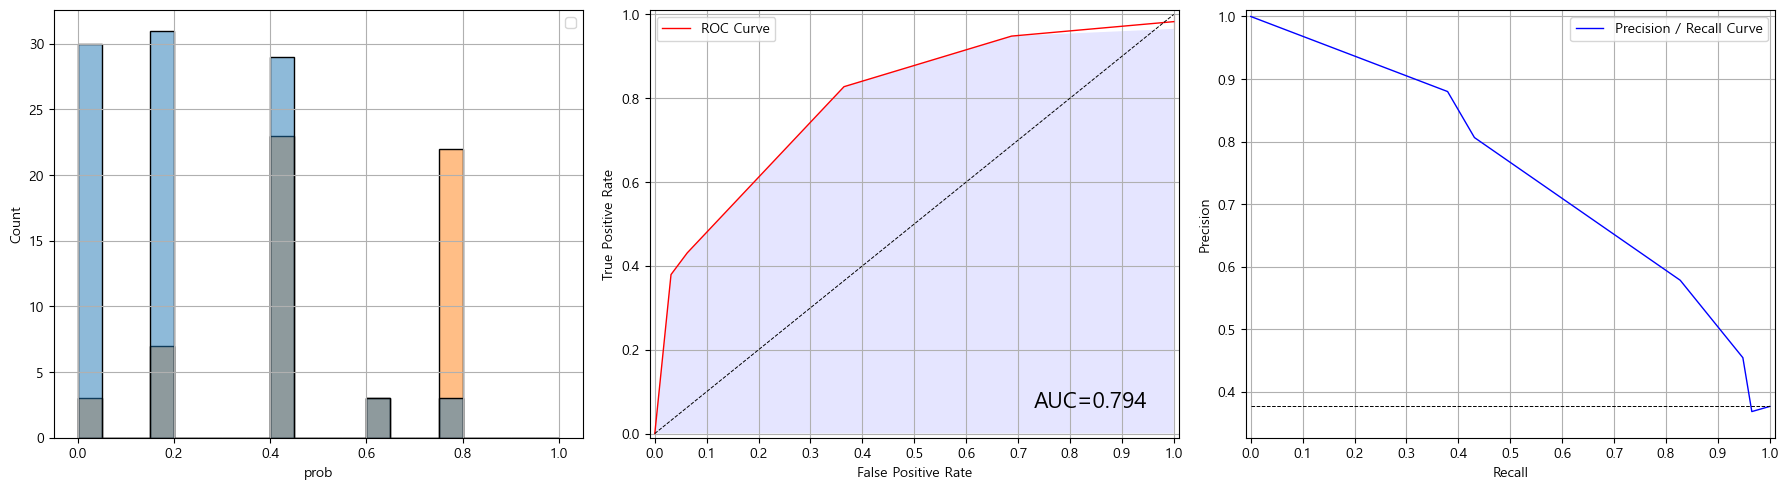


[학습곡선]


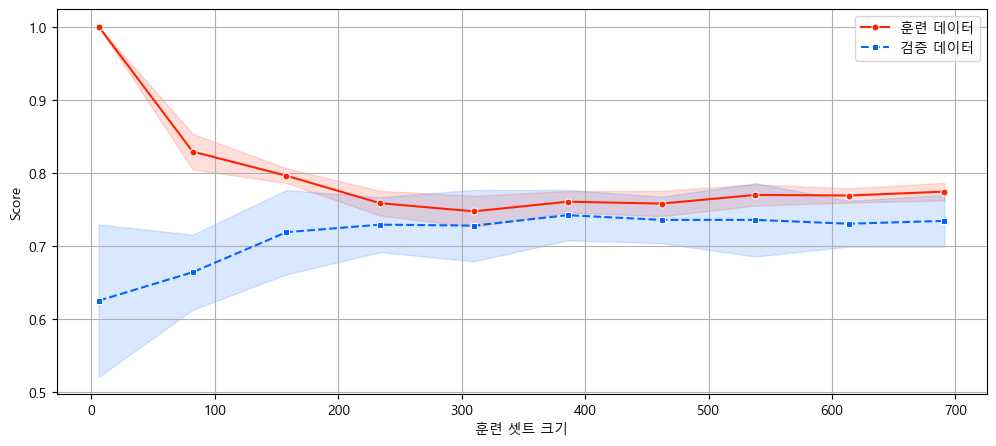

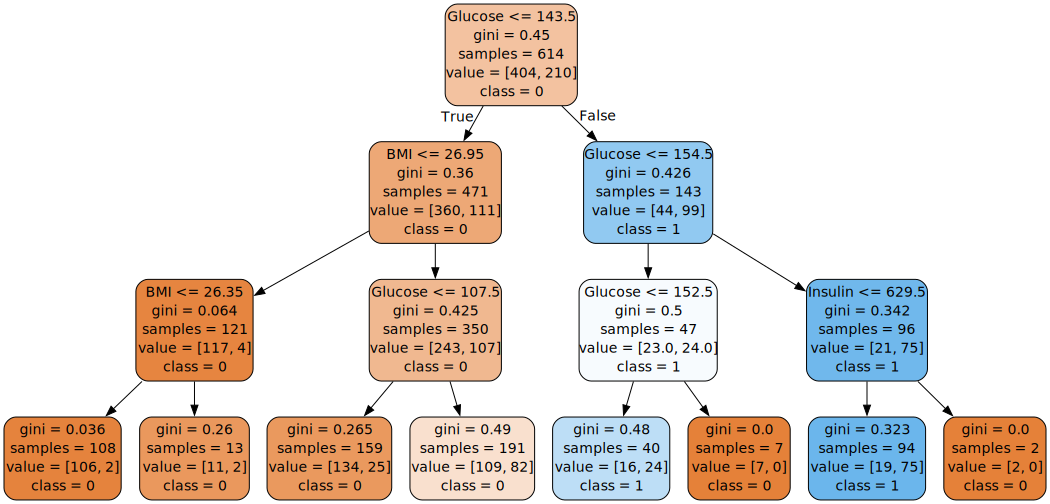

In [144]:
my_classification_result(estimator, x_train, y_train, x_test, y_test)

### [5] 모듈화 기능 확인

#### (1) 시각화 모듈

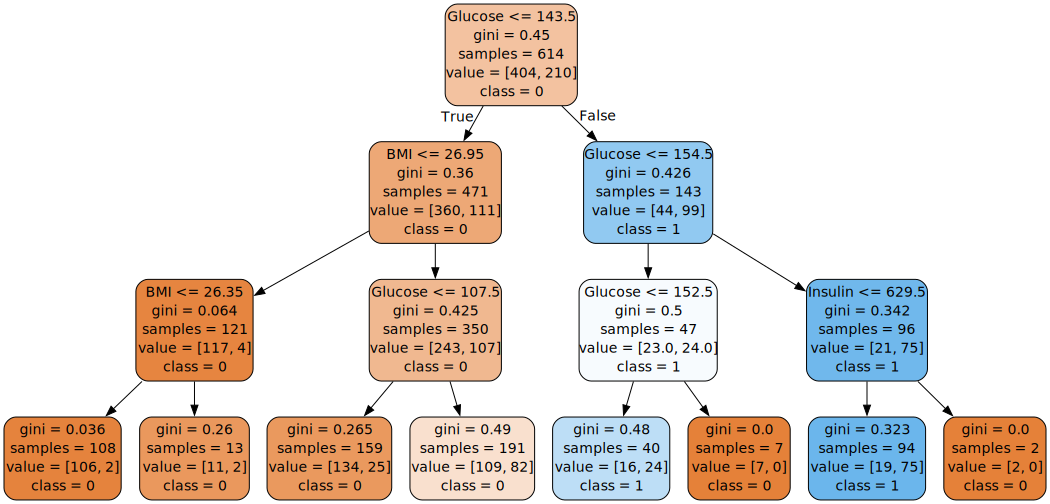

In [145]:
my_tree(estimator)

#### (2) 분석 모듈

<class 'sklearn.tree._classes.DecisionTreeClassifier'>는 n_jobs를 허용하지 않음
[교차검증 TOP5]
+----+---------------------+--------------------+-------------+-------------+-------------------+
|    |   min_samples_split |   min_samples_leaf |   max_depth | criterion   |   mean_test_score |
|----+---------------------+--------------------+-------------+-------------+-------------------|
| 44 |                   4 |                  3 |           3 | entropy     |           0.73456 |
| 43 |                   3 |                  3 |           3 | entropy     |           0.73456 |
| 42 |                   2 |                  3 |           3 | entropy     |           0.73456 |
|  6 |                   2 |                  3 |           3 | gini        |          0.732933 |
|  7 |                   3 |                  3 |           3 | gini        |          0.732933 |
+----+---------------------+--------------------+-------------+-------------+-------------------+

[분류분석 성능평가]
+-------------------+

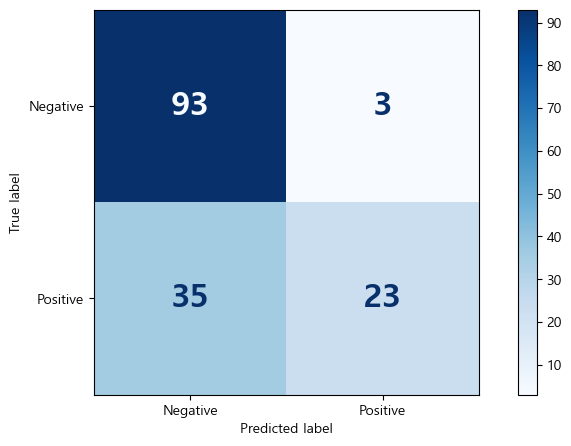


[Roc Curve]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


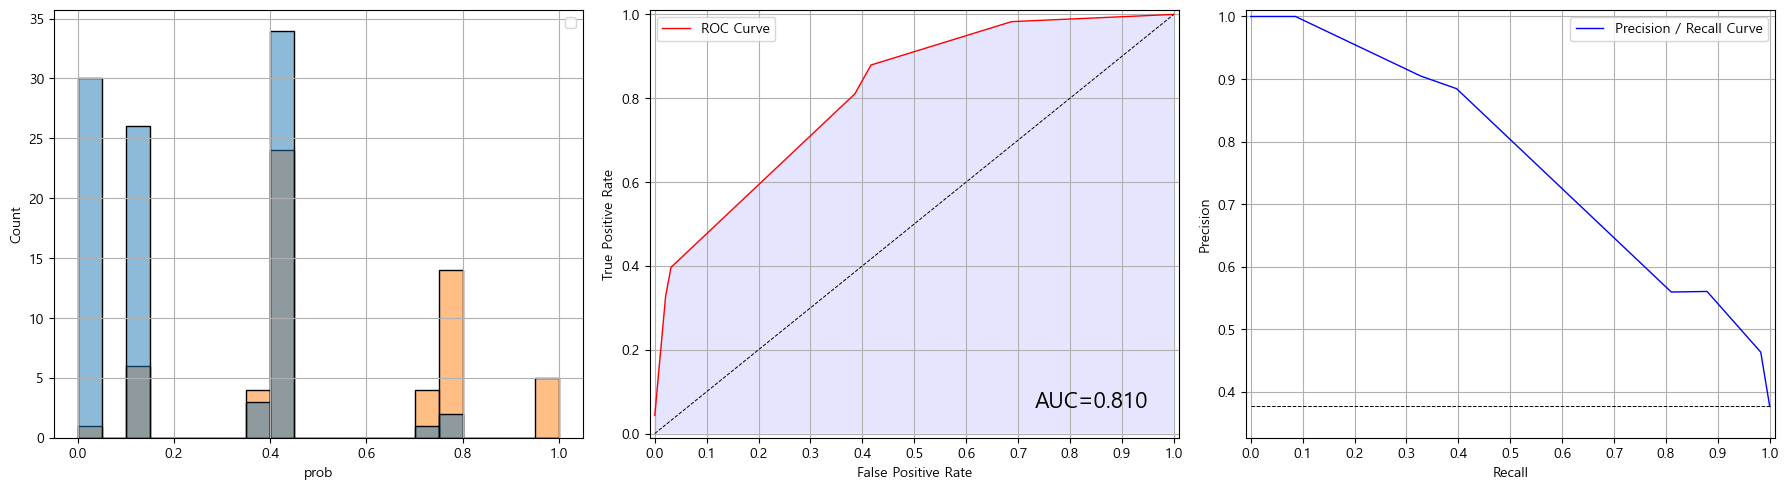


[학습곡선]


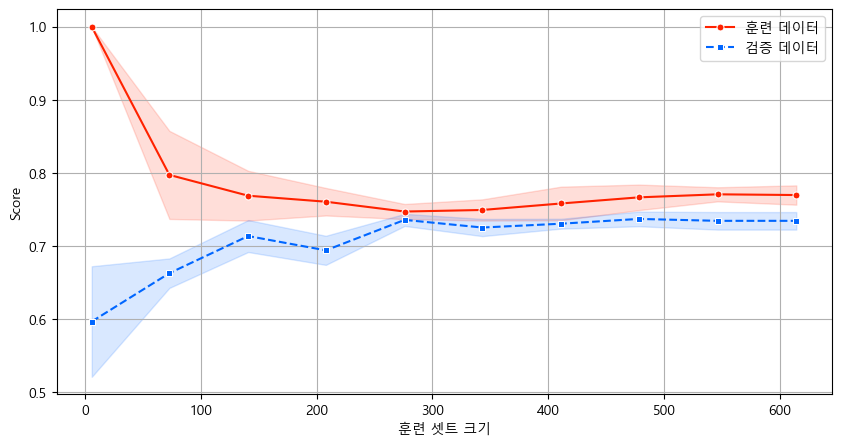

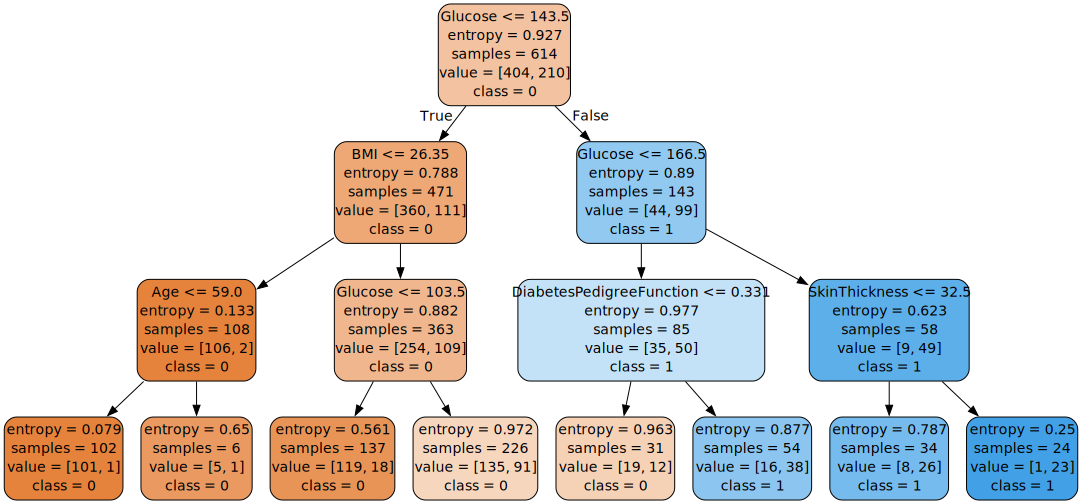

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=3)

In [146]:
my_dtree_classification(x_train, y_train, x_test, y_test)

#### (3) 모든 모형 비교하기

In [147]:
my_classification(x_train, y_train, x_test, y_test)

<class 'sklearn.naive_bayes.GaussianNB'>는 n_jobs를 허용하지 않음
<class 'sklearn.tree._classes.DecisionTreeClassifier'>는 n_jobs를 허용하지 않음
+------------------------+---------------------------+--------------------+---------------------+------------------+---------------------+---------------+------------+----------+
|                        |   의사결정계수(Pseudo R2) |   정확도(Accuracy) |   정밀도(Precision) |   재현율(Recall) |   위양성율(Fallout) |   특이성(TNR) |   F1 Score |      AUC |
|------------------------+---------------------------+--------------------+---------------------+------------------+---------------------+---------------+------------+----------|
| GaussianNB             |                         0 |           0.772727 |            0.716981 |         0.655172 |             0.15625 |       0.84375 |   0.684685 | 0.873743 |
| DecisionTreeClassifier |                         0 |           0.720779 |            0.608696 |         0.724138 |             0.28125 |       0.71875 |   0.661417 | 0.721444

{'GaussianNB': GaussianNB(),
 'DecisionTreeClassifier': DecisionTreeClassifier(),
 'LogisticRegression': LogisticRegression(C=0.001, max_iter=1000, n_jobs=1),
 'KNeighborsClassifier': KNeighborsClassifier(metric='manhattan', n_jobs=-1, weights='distance'),
 'SVC': SVC(C=10, degree=2, kernel='poly', n_jobs=-1)}